# Unravelling CCD


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import hamiltonians as hamiltonians
from pauli_matrices import *
import quantum_tools as qt

In [88]:
# Create a quantum system with a single qubit
natural_freq = 10# 10ghz   
driving_freq = 10
rabi_freq = 0.005



# CCD parameters
phi_0, epsilon_m, phase_freq, theta_m = 0, rabi_freq/4, rabi_freq, 0



# Integration parameters
tol = 10**-8
evaluation_points = 2000
evaluation_time = 5000

initial_state = np.array([0 + 0j, 1 + 0j])

## Sanity check - z expectations for ccd

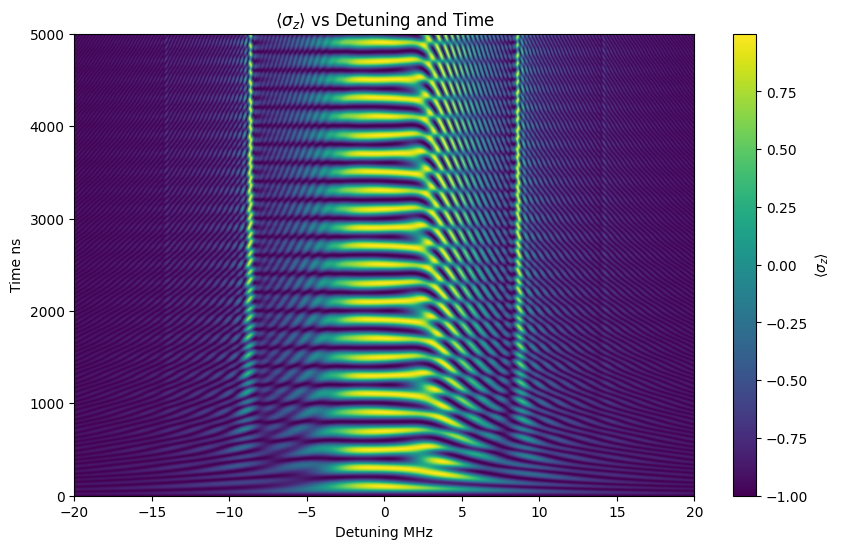

In [16]:
detunings = np.linspace(-0.02, 0.02, 1000)



# so detuing is driving - natural 
z_expectations = []
for detuning in detunings:
    times, states = qt.evolve_state(initial_state, evaluation_time, evaluation_points, hamiltonians.ccd_rwa,
                            driving_freq=driving_freq,
                            natural_freq=natural_freq-detuning, rabi_freq=rabi_freq, phi_0=phi_0,
                            epsilon_m=epsilon_m,
                            phase_freq=phase_freq,
                            theta_m=theta_m)
    z_exp = qt.calculate_expectations(states, sigma_z)
    z_expectations.append(z_exp)


# Create colour plot of z expectations with detunings and time


detunings_mhz = detunings *10**3

plt.figure(figsize=(10, 6))
plt.imshow(np.array(z_expectations).T, aspect='auto', 
           extent=[detunings_mhz[0], detunings_mhz[-1], times[0], times[-1]], 
           origin='lower', cmap='viridis')
plt.colorbar(label=r'$\langle\sigma_z\rangle$')
plt.xlabel('Detuning MHz')
plt.ylabel('Time ns')
plt.title(r'$\langle\sigma_z\rangle$ vs Detuning and Time')
plt.show()

## Now finding fidelity of CCD Scheme

In [89]:
detunings = np.linspace(-0.0, 0.009, 1000)

fidelities = []
z_expectations = []

for detuning in detunings:
    # calculate the effective the ccd time evolution unitaries
    times, Us_driving_frame = qt.calculate_unitaries(1, evaluation_time, evaluation_points,hamiltonians.ccd_rwa,
                            driving_freq=driving_freq,
                            natural_freq=natural_freq-detuning, rabi_freq=rabi_freq, phi_0=phi_0,
                            epsilon_m=epsilon_m,
                            phase_freq=phase_freq,
                            theta_m=theta_m)
    
    # rotate the unitaries to some frame
    transformed_Us  = qt.phase_boost_unitaries(Us_driving_frame, 0, times)

    states = np.array([U@initial_state for U in transformed_Us])
    z_exp = qt.calculate_expectations(states, sigma_z)
    z_expectations.append(z_exp)

    fid = qt.calculate_fidelities(np.eye(2), transformed_Us, 2)
    fidelities.append(fid)


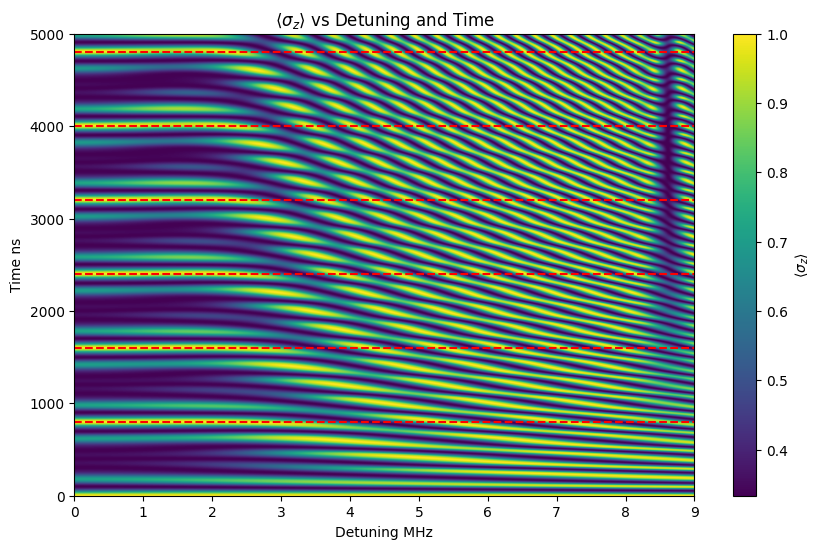

In [90]:

detunings_mhz = detunings *10**3

plt.figure(figsize=(10, 6))
plt.imshow(np.array(fidelities).T, aspect='auto', 
           extent=[detunings_mhz[0], detunings_mhz[-1], times[0], times[-1]], 
           origin='lower', cmap='viridis')
plt.colorbar(label=r'$\langle\sigma_z\rangle$')
plt.xlabel('Detuning MHz')
plt.ylabel('Time ns')
plt.title(r'$\langle\sigma_z\rangle$ vs Detuning and Time')


#add a horizontal line at the 4* the rabi period and 8* etc
for i in range(1, 7):
    plt.axhline(y=i*4/rabi_freq, color='r', linestyle='--')



plt.show()



### First Qubit Fidelities


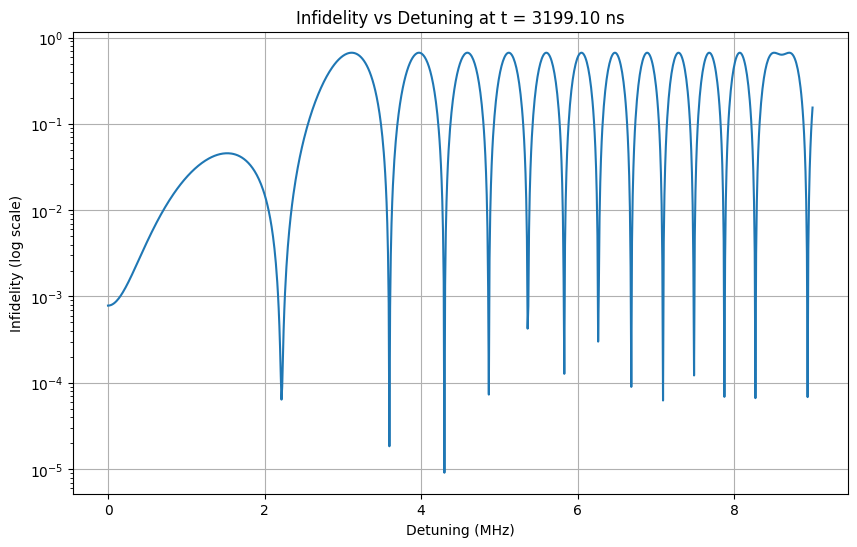

In [94]:
# Calculate the time index closest to 4/rabi_freq
optimal_time = 16/rabi_freq
time_index = np.argmin(np.abs(times - optimal_time))

# Extract fidelities at that time for all detunings
fidelities_at_time = np.array([fid[time_index] for fid in fidelities])

# Plot infidelity vs detuning
plt.figure(figsize=(10, 6))
plt.semilogy(detunings_mhz, 1 - fidelities_at_time)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Infidelity (log scale)')
plt.title(f'Infidelity vs Detuning at t = {times[time_index]:.2f} ns')
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


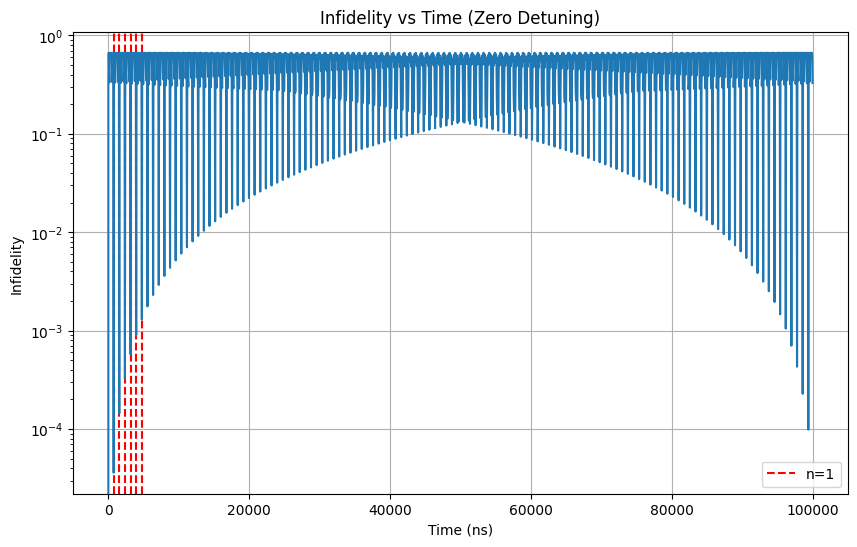

In [186]:
first_fid_time = 100000
first_fid_points = 50000

tol = 10**-25

# Calculate unitaries for zero detuning case
times, Us_driving_frame = qt.calculate_unitaries(1, first_fid_time, evaluation_points, 
                                               hamiltonians.ccd_rwa,
                                               driving_freq=driving_freq,
                                               natural_freq=natural_freq, 
                                               rabi_freq=rabi_freq, 
                                               phi_0=phi_0,
                                               epsilon_m=epsilon_m,
                                               phase_freq=phase_freq,
                                               theta_m=theta_m,
                                               rtol=tol, atol=tol)

# Transform unitaries and calculate fidelity
transformed_Us = qt.phase_boost_unitaries(Us_driving_frame, 0, times)
fidelity = qt.calculate_fidelities(np.eye(2), transformed_Us, 2)

# Plot fidelity vs time
plt.figure(figsize=(10, 6))


# Add vertical lines at optimal measurement points
for n in range(1, 7):
    optimal_time = n * 4/rabi_freq
    plt.axvline(x=optimal_time, color='r', linestyle='--', 
                label=f'n={n}' if n==1 else None)
plt.xlabel('Time (ns)')
plt.ylabel('Infidelity')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Infidelity vs Time (Zero Detuning)')
plt.legend()
plt.grid(True)
plt.plot(times, 1 - fidelity)  # Plot infidelity instead of fidelity
plt.show()

so notably for this the electron coherence time is probably around 10micros so this is not that bad - we seem to be limitted by a few things potentially - resolution etc. However for long times exponential decay is seen - consistent with infidelity decay

### now look at slice in of fidelities at one detuning

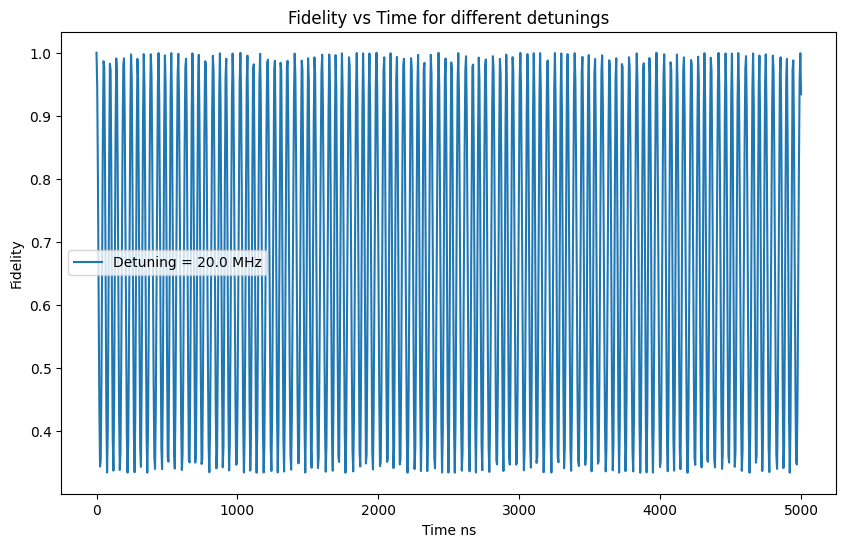

In [17]:
# plot the fidelity vs time for a few different detunings

plt.figure(figsize=(10, 6))
plt.plot(times, fidelities[-1], label=f'Detuning = {detunings[-1]*10**3} MHz')
plt.xlabel('Time ns')
plt.ylabel('Fidelity')
plt.legend()
plt.title('Fidelity vs Time for different detunings')
plt.show()


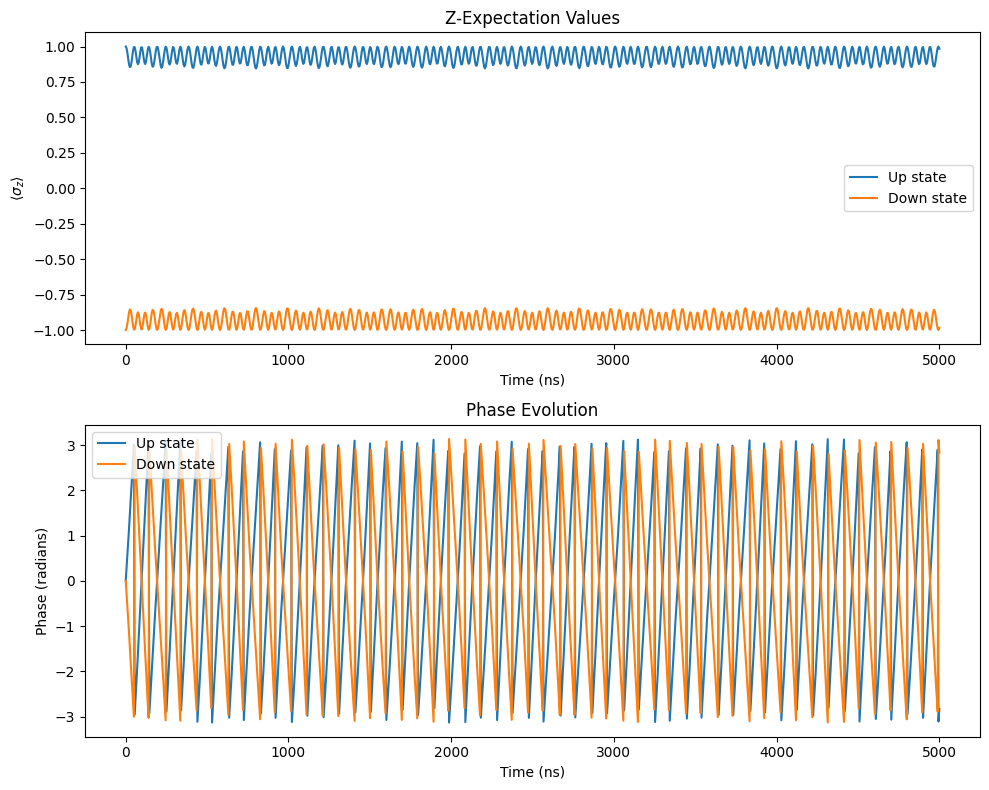

In [18]:
# Create initial states
up_state = np.array([1 + 0j, 0 + 0j])
down_state = np.array([0 + 0j, 1 + 0j])

# Calculate evolution for both states
up_states = np.array([U @ up_state for U in transformed_Us])
down_states = np.array([U @ down_state for U in transformed_Us])
# Calculate z expectations
up_z_exp = qt.calculate_expectations(up_states, sigma_z)
down_z_exp = qt.calculate_expectations(down_states, sigma_z)

# Calculate phases (using the first component of each state)
# Calculate phases - taking angle of the largest component for each state
up_phases = np.angle(up_states[:, np.argmax(np.abs(up_states[0]))])
down_phases = np.angle(down_states[:, np.argmax(np.abs(down_states[0]))])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Z expectations
ax1.plot(times, up_z_exp, label='Up state')
ax1.plot(times, down_z_exp, label='Down state')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel(r'$\langle\sigma_z\rangle$')
ax1.set_title('Z-Expectation Values')
ax1.legend()

# Plot phases
ax2.plot(times, up_phases, label='Up state')
ax2.plot(times, down_phases, label='Down state')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase Evolution')
ax2.legend()

plt.tight_layout()
plt.show()

Get spectrum of the fidelity at the edge of the plot

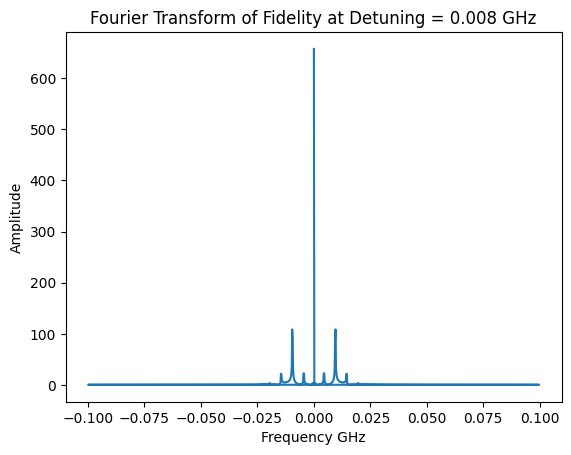

In [ ]:
det_index = -1
# take ft of the fidelity with time
fidelity_ft = np.abs(np.fft.fft(fidelities[det_index]))
frequencies = np.fft.fftfreq(len(fidelities[det_index]), d=times[1]-times[0])

plt.plot(frequencies, fidelity_ft)
plt.xlabel('Frequency GHz')
plt.ylabel('Amplitude')
plt.title(f'Fourier Transform of Fidelity at Detuning = {detunings[det_index]:.3f} GHz')
plt.show()

### Testing if the sidebands are spectral leakage due to window

In [87]:
evaluation_time_fft = 20000
evaluation_points_fft = 4000

detuning = 0.02
tol = 10**-12

times, Us_driving_frame = qt.calculate_unitaries(1, evaluation_time_fft, evaluation_points_fft,hamiltonians.ccd_rwa,
                        driving_freq=driving_freq,
                        natural_freq=natural_freq-0.1, rabi_freq=rabi_freq, phi_0=phi_0,
                        epsilon_m=epsilon_m,
                        phase_freq=phase_freq,
                        theta_m=theta_m,
                        rtol=tol, atol=tol)


fids = qt.calculate_fidelities(np.eye(2), Us_driving_frame, 2)



fidelity_ft = np.abs(np.fft.fft(fids))
frequencies = np.fft.fftfreq(len(fids), d=times[1]-times[0])



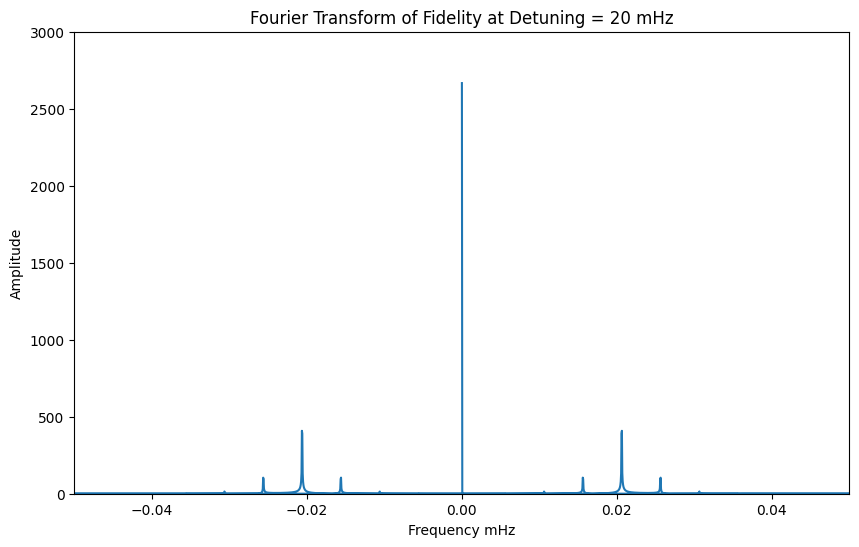

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(frequencies, fidelity_ft)
plt.xlabel('Frequency mHz')
plt.ylabel('Amplitude')
plt.xlim(-0.05, 0.05)
plt.ylim(0,3000)
plt.title(f'Fourier Transform of Fidelity at Detuning = 20 mHz')
plt.show()

## Try and graph the fidelity primary freqency against detuning

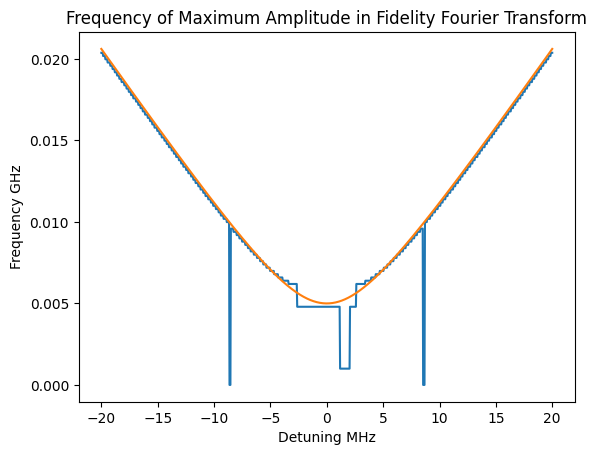

In [31]:


fidelity_frequency = []
effective_rabis = []
for det_index in range(len(detunings)):
    # take ft of the fidelity with time
    fidelity_ft = np.abs(np.fft.fft(fidelities[det_index]))
    frequencies = np.fft.fftfreq(len(fidelities[det_index]), d=times[1]-times[0])
    # the frequency of the maximum amplitude that is not at 0 frequency or negative frequency

    max_freq = frequencies[np.argmax(fidelity_ft[1:(len(fidelity_ft)//2)])]
    fidelity_frequency.append(max_freq)

    effective_rabi = np.sqrt(rabi_freq**2 + (detunings[det_index])**2)
    effective_rabis.append(effective_rabi)


plt.plot(detunings*10**3, fidelity_frequency)
plt.plot(detunings*10**3, effective_rabis)
plt.xlabel('Detuning MHz')
plt.ylabel('Frequency GHz')
plt.title('Frequency of Maximum Amplitude in Fidelity Fourier Transform')
plt.show()

In [70]:
min_freq_index = np.argmin(fidelity_frequency)
min_detuning = detunings[min_freq_index]
min_freq = fidelity_frequency[min_freq_index]

print(f"Minimum frequency: {min_freq:.6f} GHz")
print(f"Corresponding detuning: {min_detuning*1000:.3f} MHz")

Minimum frequency: 0.000000 GHz
Corresponding detuning: -8.629 MHz


### this appears as a very good match? - potentially not perfect 
- also needs to be investigates - the 'feature' - read ccd paper
- the other lobes to the ft

## trying to rotate out the effective rabi frequency

In [109]:
detunings = np.linspace(-0.02, 0.02, 1000)

fidelities = []
z_expectations = []

for detuning in detunings:
    # calculate the effective the ccd time evolution unitaries
    times, Us_driving_frame = qt.calculate_unitaries(1, evaluation_time, evaluation_points,hamiltonians.ccd_rwa,
                            driving_freq=driving_freq,
                            natural_freq=natural_freq-detuning, rabi_freq=rabi_freq, phi_0=phi_0,
                            epsilon_m=epsilon_m,
                            phase_freq=phase_freq,
                            theta_m=theta_m)
    
    # rotate the unitaries to some frame
    effective_rabi = np.sign(detuning)*np.sqrt(rabi_freq**2 + detuning**2)
    transformed_Us  = qt.phase_boost_unitaries(Us_driving_frame, effective_rabi, times)


    fid = qt.calculate_fidelities(np.eye(2), transformed_Us, 2)
    fidelities.append(fid)


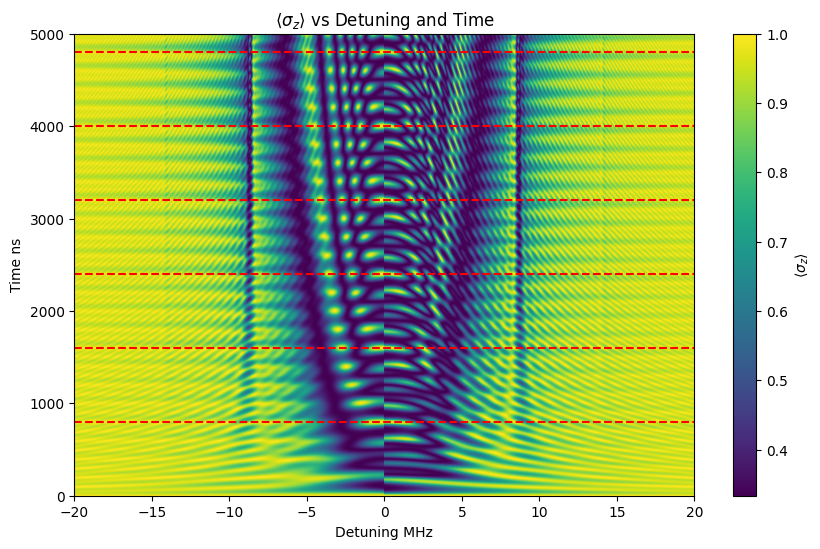

In [110]:

detunings_mhz = detunings *10**3

plt.figure(figsize=(10, 6))
plt.imshow(np.array(fidelities).T, aspect='auto', 
           extent=[detunings_mhz[0], detunings_mhz[-1], times[0], times[-1]], 
           origin='lower', cmap='viridis')
plt.colorbar(label=r'$\langle\sigma_z\rangle$')
plt.xlabel('Detuning MHz')
plt.ylabel('Time ns')
plt.title(r'$\langle\sigma_z\rangle$ vs Detuning and Time')


#add a horizontal line at the 4* the rabi period and 8* etc
for i in range(1, 7):
    plt.axhline(y=i*4/rabi_freq, color='r', linestyle='--')



plt.show()



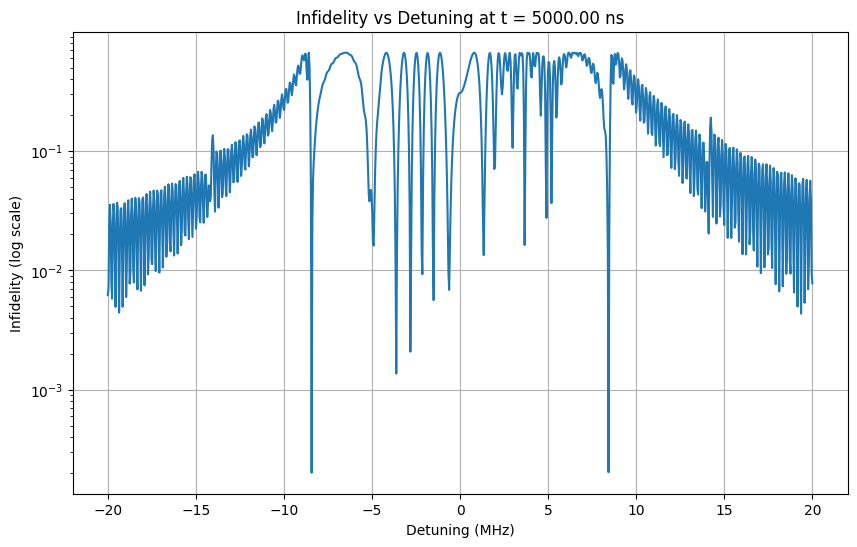

In [111]:
# Choose a specific time index (e.g., half way through the evolution)
time_index = len(times)-1

# Extract fidelities at that time for all detunings
fidelities_at_time = np.array([fid[time_index] for fid in fidelities])

# Plot fidelity vs detuning
plt.figure(figsize=(10, 6))
plt.semilogy(detunings_mhz, 1-fidelities_at_time)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Infidelity (log scale)')
plt.title(f'Infidelity vs Detuning at t = {times[time_index]:.2f} ns')
plt.grid(True)
plt.show()

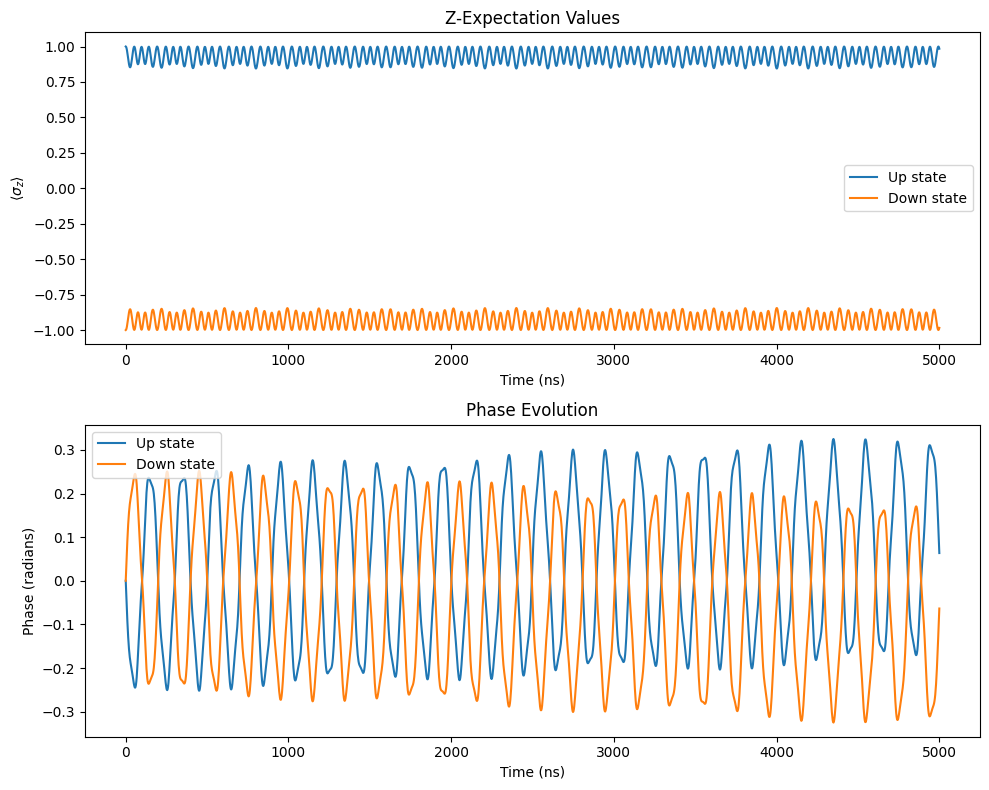

In [112]:
# Create initial states
up_state = np.array([1 + 0j, 0 + 0j])
down_state = np.array([0 + 0j, 1 + 0j])

# Calculate evolution for both states
up_states = np.array([U @ up_state for U in transformed_Us])
down_states = np.array([U @ down_state for U in transformed_Us])
# Calculate z expectations
up_z_exp = qt.calculate_expectations(up_states, sigma_z)
down_z_exp = qt.calculate_expectations(down_states, sigma_z)

# Calculate phases (using the first component of each state)
# Calculate phases - taking angle of the largest component for each state
up_phases = np.angle(up_states[:, np.argmax(np.abs(up_states[0]))])
down_phases = np.angle(down_states[:, np.argmax(np.abs(down_states[0]))])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Z expectations
ax1.plot(times, up_z_exp, label='Up state')
ax1.plot(times, down_z_exp, label='Down state')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel(r'$\langle\sigma_z\rangle$')
ax1.set_title('Z-Expectation Values')
ax1.legend()

# Plot phases
ax2.plot(times, up_phases, label='Up state')
ax2.plot(times, down_phases, label='Down state')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase Evolution')
ax2.legend()

plt.tight_layout()
plt.show()

looking at the newly rotated system to see how good it is

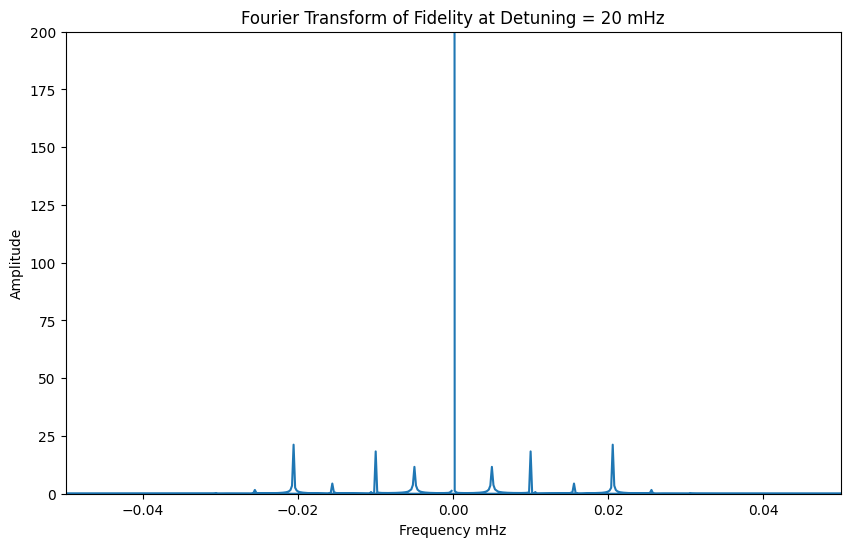

In [114]:
fids = qt.calculate_fidelities(np.eye(2), transformed_Us, 2)



fidelity_ft = np.abs(np.fft.fft(fids))
frequencies = np.fft.fftfreq(len(fids), d=times[1]-times[0])

plt.figure(figsize=(10, 6))
plt.plot(frequencies, fidelity_ft)
plt.xlabel('Frequency mHz')
plt.ylabel('Amplitude')
plt.xlim(-0.05, 0.05)
plt.ylim(0,200)
plt.title(f'Fourier Transform of Fidelity at Detuning = 20 mHz')
plt.show()


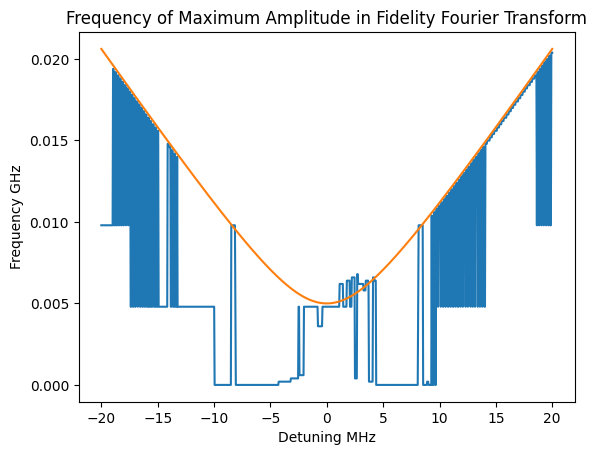

In [115]:


fidelity_frequency = []
effective_rabis = []
for det_index in range(len(detunings)):
    # take ft of the fidelity with time
    fidelity_ft = np.abs(np.fft.fft(fidelities[det_index]))
    frequencies = np.fft.fftfreq(len(fidelities[det_index]), d=times[1]-times[0])
    # the frequency of the maximum amplitude that is not at 0 frequency or negative frequency

    max_freq = frequencies[np.argmax(fidelity_ft[1:(len(fidelity_ft)//2)])]
    fidelity_frequency.append(max_freq)

    effective_rabi = np.sqrt(rabi_freq**2 + (detunings[det_index])**2)
    effective_rabis.append(effective_rabi)


plt.plot(detunings*10**3, fidelity_frequency)
plt.plot(detunings*10**3, effective_rabis)
plt.xlabel('Detuning MHz')
plt.ylabel('Frequency GHz')
plt.title('Frequency of Maximum Amplitude in Fidelity Fourier Transform')
plt.show()

## Testing how this rotating frame works in the long term

In [183]:


evaluation_time_long = 50000 # this should be longer than the longest time period of the rabi oscillations but still relevant
evaluation_points_long = 1000

detuning = 0.02
tol = 10**-7

times, Us_driving_frame = qt.calculate_unitaries(1, evaluation_time_long, evaluation_points_long,hamiltonians.ccd_rwa,
                        driving_freq=driving_freq,
                        natural_freq=natural_freq-detuning, rabi_freq=rabi_freq, phi_0=phi_0,
                        epsilon_m=epsilon_m,
                        phase_freq=phase_freq,
                        theta_m=theta_m,
                        rtol=tol, atol=tol)



In [184]:
effective_rabi = np.sign(detuning)*np.sqrt(rabi_freq**2 + detuning**2)
floquet_freq = (64780073.21345833*10**-9)/np.pi
print(effective_rabi, floquet_freq)

transformed_Us_floq  = qt.phase_boost_unitaries(Us_driving_frame, floquet_freq, times)
transformed_Us_rab = qt.phase_boost_unitaries(Us_driving_frame, effective_rabi, times)

fids_floq = qt.calculate_fidelities(np.eye(2), transformed_Us_floq, 2)
fids_rab = qt.calculate_fidelities(np.eye(2), transformed_Us_rab, 2)
fids_raw = qt.calculate_fidelities(np.eye(2), Us_driving_frame, 2)

0.020615528128088305 0.020620137731553547


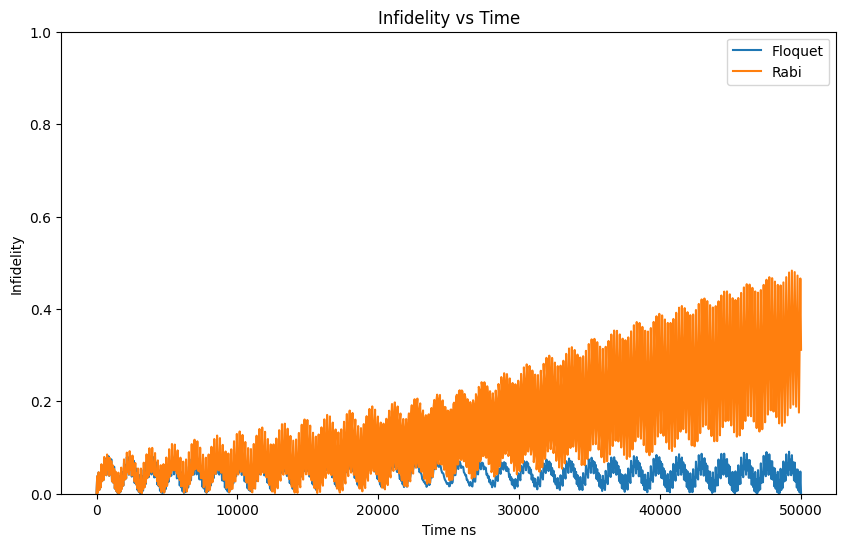

In [185]:
# plot the infidelity vs time for on a log plot
plt.figure(figsize=(10, 6))

plt.plot(times, 1-fids_floq)
plt.plot(times, 1-fids_rab)

# plt.plot(times, 1-fids_raw)
plt.xlabel('Time ns')
plt.ylabel('Infidelity')
# plt.yscale('log')
# plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.title('Infidelity vs Time')
plt.legend(['Floquet', 'Rabi', 'Raw'])
plt.show()

## using floquet freq for a range of dets